# Advanced DL and RL: Домашнее задание 2

Николай Горев

MADE-DS-32

In [1]:
import numpy as np
import random
import copy

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from ttt import TicTacToe

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

### Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

1.	Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2.	Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

**Disclaimer:** начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.


In [3]:
env_333 = TicTacToe(n_rows=3, n_cols=3, n_win=3)

In [4]:
def inv_state(s):
    return ''.join([str(2 - int(n)) for n in s])

In [5]:
class randomAgent(object):
    def __init__(self):
        self.index_best_action = True
        pass

    def get_best_action(self, state, n_actions=None):
        if n_actions is None:
            n_actions = np.sum(np.array(list(state)) == '1')
        return np.random.randint(n_actions)

In [6]:
random_agent = randomAgent()

In [7]:
def test_one_game(env, pi_crosses, pi_naughts):
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        n_actions = len(actions)
        if env.curTurn == 1:
            if pi_crosses.index_best_action:
                a = actions[pi_crosses.get_best_action(s, n_actions)]
            else:
                a = pi_crosses.get_best_action(s)
        else:
            if pi_naughts.index_best_action:
                a = actions[pi_naughts.get_best_action(inv_state(s), n_actions)]
            else:
                a = pi_naughts.get_best_action(inv_state(s))
        observation, reward, done, info = env.step(a)
        if reward < -1:
            print("Ход в занятую клетку")
    return reward

In [8]:
def test_perf(env, pi_crosses, pi_naughts, num_games=1000):
    crosses_wins = 0
    naughts_wins = 0
    for _ in range(num_games):
        reward = test_one_game(env, pi_crosses, pi_naughts)
        if reward == 1:
            crosses_wins += 1
        elif reward == -1:
            naughts_wins += 1
    return crosses_wins / num_games, naughts_wins / num_games

In [9]:
test_perf(env_333, random_agent, random_agent)

(0.59, 0.284)

In [10]:
class QLearningAgent:
    def __init__(self, alpha, gamma):
        self.index_best_action = True

        self.Qvalues = {}
        self.alpha = alpha
        self.gamma = gamma
        
    def get_n_actions(self, state):
        return np.sum(np.array(list(state)) == '1')        
        
    def get_Qs(self, state, n_actions=None):
        if state not in self.Qvalues:
            if n_actions is None:
                n_actions = self.get_n_actions(state)
            #self.Qvalues[state] = np.zeros(n_actions)
            self.Qvalues[state] = np.random.random(n_actions) * 0.01 - 0.005
        return self.Qvalues[state]

    def get_V(self, state):
        return np.max(self.get_Qs(state))

    # Q(s,a) := Q(s,a) + alpha * (r + gamma * V(s') - Q(s,a))
    def update(self, state, n_action, reward, next_state):
        Q = self.get_Qs(state)[n_action]
        if next_state is None:
            V = 0
        else:
            V = self.get_V(next_state)
            
        self.Qvalues[state][n_action] = Q + self.alpha * (reward + self.gamma * V - Q)

    def get_best_action(self, state, n_actions=None):
        return np.argmax(self.get_Qs(state, n_actions))

    # epsilon-greedy action
    def get_action(self, state, epsilon, n_actions=None):
        if np.random.random() > epsilon:
            return self.get_best_action(state, n_actions)
        else:
            if n_actions is None:
                n_actions = self.get_n_actions(state)
            return np.random.randint(n_actions)

In [11]:
def QL_train(env, QL_agent, max_epsilon, t_max, perf_interval):
    performances_crosses = []
    performances_naughts = []
    for t in range(t_max):
        
        epsilon = max_epsilon * (t_max - t) / t_max

        if t % perf_interval == 0:
            p, _ = test_perf(env, QL_agent, random_agent)
            performances_crosses.append((t, p))
            _, p = test_perf(env, random_agent, QL_agent)
            performances_naughts.append((t, p))
            
        done = False
        env.reset()

        state_0, actions_0 = env.getHash(), env.getEmptySpaces()
        n_action_0 = QL_agent.get_action(state_0, epsilon, len(actions_0))
        observation, reward, done, info = env.step(actions_0[n_action_0])
        state_1, actions_1 = observation[0], observation[1]
        curTurn = env.curTurn
        state_1 = inv_state(state_1)
        while not done:
            n_action_1 = QL_agent.get_action(state_1, epsilon, len(actions_1))
            observation, reward, done, info = env.step(actions_1[n_action_1])
            if done: 
                QL_agent.update(state_0, n_action_0, -reward * curTurn, None)
                QL_agent.update(state_1, n_action_1, reward * curTurn, None)
                break

            next_state = observation[0]
            curTurn = env.curTurn
            if curTurn == -1:
                next_state = inv_state(next_state)
                
            QL_agent.update(state_0, n_action_0, reward, next_state)
            state_0, actions_0 = state_1, actions_1
            state_1, actions_1 = next_state, observation[1]
            n_action_0 = n_action_1
            
    return performances_crosses, performances_naughts

In [12]:
alpha = 0.1
gamma = 1.
QL_agent_333 = QLearningAgent(alpha, gamma)

In [13]:
max_epsilon = 0.5
t_max = 100000
perf_interval = t_max // 10
performances_crosses, performances_naughts = QL_train(env_333, 
                                                      QL_agent_333, 
                                                      max_epsilon,
                                                      t_max, 
                                                      perf_interval)

In [14]:
print(test_perf(env_333, QL_agent_333, random_agent))
print(test_perf(env_333, random_agent, QL_agent_333))
print(test_perf(env_333, QL_agent_333, QL_agent_333))

(0.92, 0.0)
(0.016, 0.822)
(0.0, 0.0)


In [15]:
def plot_results(performances_crosses, performances_naughts):
    steps = [x[0] for x in performances_crosses]
    rewards_crosses = [x[1] for x in performances_crosses]
    rewards_naughts = [x[1] for x in performances_naughts]
    plt.plot(steps, rewards_crosses, label='x')
    plt.plot(steps, rewards_naughts, label='o')
    plt.grid()
    plt.xlabel("Шаг обучения")
    plt.ylabel("Доля выигрышей")
    plt.title("Игры против игрока со случайными ходами")
    plt.legend()
    plt.ylim(0, 1.1)

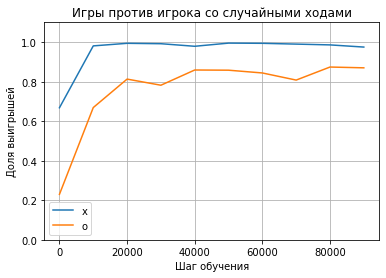

In [16]:
plot_results(performances_crosses, performances_naughts)

### 4x4x4 Q-learning

In [17]:
env_444 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
test_perf(env_444, random_agent, random_agent)

(0.325, 0.228)

In [18]:
alpha = 0.05
gamma = 1.
QL_agent_444 = QLearningAgent(alpha, gamma)

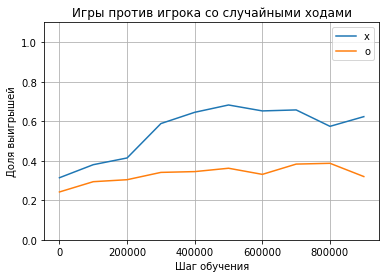

In [19]:
max_epsilon = 0.5
t_max = 1000000
perf_interval = t_max // 10
performances_crosses, performances_naughts = QL_train(env_444, 
                                                      QL_agent_444, 
                                                      max_epsilon,
                                                      t_max,
                                                      perf_interval
                                                     )
plot_results(performances_crosses, performances_naughts)

In [20]:
print(test_perf(env_444, QL_agent_444, random_agent))
print(test_perf(env_444, random_agent, QL_agent_444))
print(test_perf(env_444, QL_agent_444, QL_agent_444))

(0.519, 0.148)
(0.272, 0.302)
(0.0, 0.0)


### Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3.	Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
4.	Реализуйте Double DQN и/или Dueling DQN.


In [21]:
class ReplayBufferSet(Dataset):
    def __init__(self, length, environment):
        self.len = length
        self.env = environment
        
        self.store_index = 0
        
        self.s = np.zeros((length, 2, environment.n_rows, environment.n_cols))
        self.a = np.zeros((length, 2))
        self.r = np.zeros(length)
        self.done = np.zeros(length)
        self.next_s = np.zeros((length, 2, environment.n_rows, environment.n_cols))
        
        counter = 0
        while counter < length:
            self.env.reset()
            state_0 = copy.deepcopy(self.env.board)
            actions_0 = self.env.getEmptySpaces()
            action_0 = random.choice(actions_0)
            observation, reward, done, info = self.env.step(action_0)
            curTurn = self.env.curTurn
            state_1 = copy.deepcopy(self.env.board) * curTurn
            actions_1 = observation[1]
            while not done:
                action_1 = random.choice(actions_1)
                observation, reward, done, info = self.env.step(action_1)

                curTurn = self.env.curTurn
                next_state = copy.deepcopy(self.env.board) * curTurn
                
                if done: 
                    self.s[counter, 0, :, :] = state_0 == 1
                    self.s[counter, 1, :, :] = state_0 == -1
                    self.a[counter, :] = action_0
                    self.r[counter] = reward * curTurn
                    self.done[counter] = done
                    self.next_s[counter, 0, :, :] = next_state == 1
                    self.next_s[counter, 1, :, :] = next_state == -1
                    counter += 1
                    if counter >= length:
                        break
                    self.s[counter, 0, :, :] = state_1 == 1
                    self.s[counter, 1, :, :] = state_1 == -1
                    self.a[counter, :] = action_1
                    self.r[counter] = -reward * curTurn
                    self.done[counter] = done
                    self.next_s[counter, 0, :, :] = next_state == 1
                    self.next_s[counter, 1, :, :] = next_state == -1
                    counter += 1
                    break
                else:
                    self.s[counter, 0, :, :] = state_0 == 1
                    self.s[counter, 1, :, :] = state_0 == -1
                    self.a[counter, :] = action_0
                    self.r[counter] = 0
                    self.done[counter] = done
                    self.next_s[counter, 0, :, :] = next_state == 1
                    self.next_s[counter, 1, :, :] = next_state == -1
                    counter += 1

                if counter >= length:
                    break

                state_0, actions_0 = state_1, actions_1
                state_1, actions_1 = next_state, observation[1]
                action_0 = action_1    

        self.s = torch.from_numpy(self.s).float()
        self.next_s = torch.from_numpy(self.next_s).float()

    def __getitem__(self, index):
        a = self.a[index]
        r = self.r[index]
        done = self.done[index]

        if type(index) == slice:
            index = range(self.len)[index]
        index = torch.from_numpy(np.array(index)).long()

        s = torch.index_select(self.s, 0, index)
        next_s = torch.index_select(self.next_s, 0, index)

        return {'s': s, 'a': a, 'r': r, 'done': done, 'next_s': next_s}
    
    def __len__(self):
        return self.len
    
    def store(self, s, a, r, done, next_s):
        self.s[self.store_index, :, :, :] = s
        self.a[self.store_index, :] = a
        self.r[self.store_index] = r
        self.done[self.store_index] = done
        self.next_s[self.store_index, :, :, :] = next_s
        self.store_index = (self.store_index + 1) % self.len

In [22]:
replay_buffer_333 = ReplayBufferSet(10000, env_333)

In [23]:
# трехслойная сверточная сеть
class Conv3net(nn.Module):
    def __init__(self, n_hid_channels=16):
        super().__init__()
        
        self.conv_1 = nn.Conv2d(in_channels=2,
                              out_channels=n_hid_channels,
                              kernel_size=3,
                              padding=1
                              )
        
        self.activation_1 = nn.ReLU()
        
        self.conv_2 = nn.Conv2d(in_channels=n_hid_channels,
                              out_channels=n_hid_channels,
                              kernel_size=3,
                              padding=1
                              )

        self.activation_2 = nn.ReLU()
        
        self.conv_3 = nn.Conv2d(in_channels=n_hid_channels,
                              out_channels=1,
                              kernel_size=3,
                              padding=1
                              )
        
        self.activation_3 = nn.Tanh()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.activation_1(x)
        x = self.conv_2(x)
        x = self.activation_2(x)
        x = self.conv_3(x)
        x = self.activation_3(x)
        return x

In [24]:
class DQNAgent(object):
    def __init__(self, environment):
        self.index_best_action = False
        self.net = Conv3net()
        self.env = environment
        
    def board2matrix(self, board):
        crosses = torch.FloatTensor(board == 1)
        naughts = torch.FloatTensor(board == -1)
        actions = torch.FloatTensor(board == 0)
        m = torch.stack((crosses, naughts))
        return m, actions

    # epsilon-greedy action
    def get_action_from_board(self, board, epsilon):
        if np.random.random() > epsilon:
            m, actions = self.board2matrix(board)
            r = torch.squeeze(self.net(torch.unsqueeze(m, 0)))
            idx = torch.argmax(r - (1 - actions) * 100)
            return self.env.action_from_int(idx)
        else:
            r, c = np.where(board == 0)
            r_idx = np.random.randint(len(r))
            return r[r_idx], c[r_idx]
        
    def get_best_action(self, s):
        board = np.array([float(n) for n in s]).reshape(
            (self.env.n_rows, self.env.n_cols))
        m, actions = self.board2matrix(board - 1)
        r = torch.squeeze(self.net(torch.unsqueeze(m, 0)))
        idx = torch.argmax(r - (1 - actions) * 100)
        return self.env.action_from_int(idx)

In [25]:
DQN_agent_333 = DQNAgent(env_333)

In [26]:
def DQN_train(agent, env, replay_buffer, n_games=1000, perf_interval=100, batch_size=1000):
    performances_crosses = []
    performances_naughts = []

    max_epsilon = 0.1
    gamma = 1.0
    opt = torch.optim.Adam(agent.net.parameters())
    loss_function = nn.MSELoss()
    agent.net.eval()
    for counter in range(n_games):
        epsilon = max_epsilon * (n_games - counter) / n_games

        env.reset()
        state_0 = copy.deepcopy(env.board)
        action_0 = agent.get_action_from_board(state_0, epsilon)
        observation, reward, done, info = env.step(action_0)
        curTurn = env.curTurn
        state_1 = copy.deepcopy(env.board) * curTurn
        while not done:
            action_1 = agent.get_action_from_board(state_1, epsilon)
            observation, reward, done, info = env.step(action_1)
            curTurn = env.curTurn
            next_state = copy.deepcopy(env.board) * curTurn

            s, _ = agent.board2matrix(state_0)
            next_s, _ = agent.board2matrix(next_state)
            replay_buffer.store(s, action_0, reward * curTurn, done, next_s)
            
            if done: 
                s, _ = agent.board2matrix(state_1)
                replay_buffer.store(s, action_1, -reward * curTurn, done, next_s)
                break

            state_0 = state_1
            state_1 = next_state
            action_0 = action_1
            
        batch = replay_buffer[random.sample(range(len(replay_buffer)), batch_size)]
        next_actions = ((batch['next_s'][:, 0, :, :] != 1) & 
                        (batch['next_s'][:, 1, :, :] != 1)).long()
        Q_next = torch.squeeze(agent.net(batch['next_s'])).detach()
        V_next = torch.max((Q_next - (1 - next_actions) * 100).reshape(Q_next.shape[0], -1), dim = 1)[0]
        y = batch['done'] * batch['r'] + (1 - batch['done']) * V_next.numpy() * gamma
        
        agent.net.train()
        Q = torch.squeeze(agent.net(batch['s']))
        a = torch.LongTensor(batch['a'])
        y_hat = Q[torch.arange(batch_size), a[:,0], a[:,1]]
        
        opt.zero_grad()
        loss = loss_function(y_hat, torch.tensor(y, dtype=torch.float32))
        loss.backward()
        opt.step()
        agent.net.eval()


        if counter % perf_interval == 0:
            p, _ = test_perf(env, agent, random_agent)
            performances_crosses.append((counter, p))
            _, p = test_perf(env, random_agent, agent)
            performances_naughts.append((counter, p))

    return performances_crosses, performances_naughts

In [27]:
performances_crosses, performances_naughts = DQN_train(DQN_agent_333, 
                                                       env_333, 
                                                       replay_buffer_333)

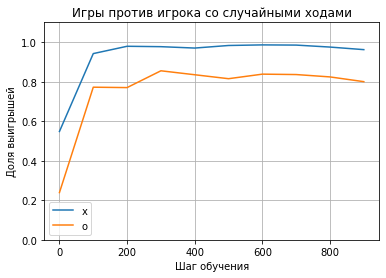

In [28]:
plot_results(performances_crosses, performances_naughts)

In [29]:
print(test_perf(env_333, DQN_agent_333, random_agent))
print(test_perf(env_333, random_agent, DQN_agent_333))
print(test_perf(env_333, DQN_agent_333, DQN_agent_333))

(0.948, 0.03)
(0.129, 0.737)
(0.0, 0.0)


In [30]:
print(test_perf(env_333, DQN_agent_333, QL_agent_333))
print(test_perf(env_333, QL_agent_333, DQN_agent_333))

(0.0, 0.0)
(1.0, 0.0)


### DQN 4x4x4

In [31]:
replay_buffer_444 = ReplayBufferSet(10000, env_444)

In [32]:
DQN_agent_444 = DQNAgent(env_444)

In [33]:
performances_crosses, performances_naughts = DQN_train(DQN_agent_444, 
                                                       env_444, 
                                                       replay_buffer_444)

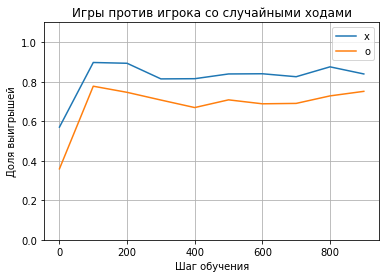

In [34]:
plot_results(performances_crosses, performances_naughts)

In [35]:
print(test_perf(env_444, DQN_agent_444, random_agent))
print(test_perf(env_444, random_agent, DQN_agent_444))
print(test_perf(env_444, DQN_agent_444, DQN_agent_444))

(0.829, 0.047)
(0.064, 0.671)
(0.0, 0.0)


In [36]:
print(test_perf(env_444, DQN_agent_444, QL_agent_444))
print(test_perf(env_444, QL_agent_444, DQN_agent_444))

(1.0, 0.0)
(0.0, 1.0)


### DQN 5x5x5

In [37]:
env_555 = TicTacToe(n_rows=5, n_cols=5, n_win=5)
replay_buffer_555 = ReplayBufferSet(10000, env_555)
DQN_agent_555 = DQNAgent(env_555)

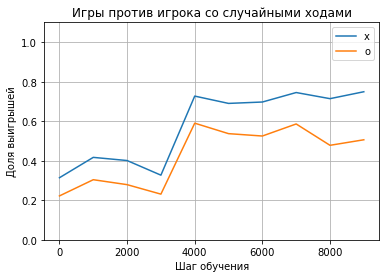

In [38]:
performances_crosses, performances_naughts = DQN_train(DQN_agent_555, 
                                                       env_555, 
                                                       replay_buffer_555,
                                                       n_games=10000, 
                                                       perf_interval=1000
                                                      )
plot_results(performances_crosses, performances_naughts)

In [39]:
print(test_perf(env_555, DQN_agent_555, random_agent))
print(test_perf(env_555, random_agent, DQN_agent_555))
print(test_perf(env_555, DQN_agent_555, DQN_agent_555))

(0.511, 0.068)
(0.12, 0.421)
(1.0, 0.0)


### Double DQN

In [40]:
class DoubleQNAgent(object):
    def __init__(self, environment):
        self.index_best_action = False
        self.net_a = Conv3net()
        self.net_b = Conv3net()
        self.env = environment
        
    def board2matrix(self, board):
        crosses = torch.FloatTensor(board == 1)
        naughts = torch.FloatTensor(board == -1)
        actions = torch.FloatTensor(board == 0)
        m = torch.stack((crosses, naughts))
        return m, actions

    # epsilon-greedy action
    def get_action_from_board(self, board, epsilon, update=0):
        if np.random.random() > epsilon:
            m, actions = self.board2matrix(board)
            if update == 1:
                r = torch.squeeze(self.net_a(torch.unsqueeze(m, 0)))
            elif update == -1:
                r = torch.squeeze(self.net_b(torch.unsqueeze(m, 0)))
            else:
                r = (torch.squeeze(self.net_a(torch.unsqueeze(m, 0))) +
                     torch.squeeze(self.net_b(torch.unsqueeze(m, 0)))) / 2.
            idx = torch.argmax(r - (1 - actions) * 100)
            return self.env.action_from_int(idx)
        else:
            r, c = np.where(board == 0)
            r_idx = np.random.randint(len(r))
            return r[r_idx], c[r_idx]
        
    def get_best_action(self, s):
        board = np.array([float(n) for n in s]).reshape(
            (self.env.n_rows, self.env.n_cols))
        m, actions = self.board2matrix(board - 1)
        r = (torch.squeeze(self.net_a(torch.unsqueeze(m, 0))) +
             torch.squeeze(self.net_b(torch.unsqueeze(m, 0)))) / 2.
        idx = torch.argmax(r - (1 - actions) * 100)
        return self.env.action_from_int(idx)

In [41]:
double_agent_333 = DoubleQNAgent(env_333)

In [42]:
def double_QN_train(agent, env, replay_buffer, n_games=1000, perf_interval=100, batch_size=100):
    performances_crosses = []
    performances_naughts = []

    max_epsilon = 0.1
    gamma = 1.0
    opt_a = torch.optim.Adam(agent.net_a.parameters())
    opt_b = torch.optim.Adam(agent.net_b.parameters())
    loss_function = nn.MSELoss()
    agent.net_a.eval()
    agent.net_b.eval()
    for counter in range(n_games):
        epsilon = max_epsilon * (n_games - counter) / n_games

        env.reset()
        state_0 = copy.deepcopy(env.board)
        action_0 = agent.get_action_from_board(state_0, epsilon)
        observation, reward, done, info = env.step(action_0)
        curTurn = env.curTurn
        state_1 = copy.deepcopy(env.board) * curTurn
        while not done:
            action_1 = agent.get_action_from_board(state_1, epsilon)
            observation, reward, done, info = env.step(action_1)
            curTurn = env.curTurn
            next_state = copy.deepcopy(env.board) * curTurn

            s, _ = agent.board2matrix(state_0)
            next_s, _ = agent.board2matrix(next_state)
            replay_buffer.store(s, action_0, reward * curTurn, done, next_s)
            
            if done: 
                s, _ = agent.board2matrix(state_1)
                replay_buffer.store(s, action_1, -reward * curTurn, done, next_s)
                break

            state_0 = state_1
            state_1 = next_state
            action_0 = action_1
            
        batch = replay_buffer[random.sample(range(len(replay_buffer)), batch_size)]
        next_actions = ((batch['next_s'][:, 0, :, :] != 1) & 
                        (batch['next_s'][:, 1, :, :] != 1)).long()

        if np.random.random() > 0.5:
            Q_next = torch.squeeze(agent.net_b(batch['next_s'])).detach()
            V_next = torch.max((Q_next - (1 - next_actions) * 100).reshape(
                Q_next.shape[0], -1), dim = 1)[0]
            y = batch['done'] * batch['r'] +\
                (1 - batch['done']) * V_next.numpy() * gamma

            agent.net_a.train()
            Q = torch.squeeze(agent.net_a(batch['s']))
            a = torch.LongTensor(batch['a'])
            y_hat = Q[torch.arange(batch_size), a[:,0], a[:,1]]
            opt_a.zero_grad()
            loss = loss_function(y_hat, torch.tensor(y, dtype=torch.float32))
            loss.backward()
            opt_a.step()
            agent.net_a.eval()
        else:
            Q_next = torch.squeeze(agent.net_a(batch['next_s'])).detach()
            V_next = torch.max((Q_next - (1 - next_actions) * 100).reshape(
                Q_next.shape[0], -1), dim = 1)[0]
            y = batch['done'] * batch['r'] +\
                (1 - batch['done']) * V_next.numpy() * gamma
            agent.net_b.train()
            Q = torch.squeeze(agent.net_b(batch['s']))
            a = torch.LongTensor(batch['a'])
            y_hat = Q[torch.arange(batch_size), a[:,0], a[:,1]]
            opt_b.zero_grad()
            loss = loss_function(y_hat, torch.tensor(y, dtype=torch.float32))
            loss.backward()
            opt_b.step()
            agent.net_b.eval()

        if counter % perf_interval == 0:
            p, _ = test_perf(env, agent, random_agent)
            performances_crosses.append((counter, p))
            _, p = test_perf(env, random_agent, agent)
            performances_naughts.append((counter, p))

    return performances_crosses, performances_naughts

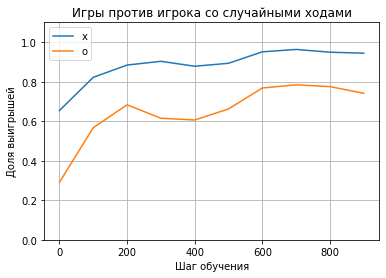

In [43]:
replay_buffer_333 = ReplayBufferSet(10000, env_333)
performances_crosses, performances_naughts = double_QN_train(double_agent_333, 
                                                       env_333, 
                                                       replay_buffer_333
                                                      )
plot_results(performances_crosses, performances_naughts)

In [44]:
print(test_perf(env_333, double_agent_333, random_agent))
print(test_perf(env_333, random_agent, double_agent_333))
print(test_perf(env_333, double_agent_333, double_agent_333))

(0.917, 0.011)
(0.193, 0.733)
(1.0, 0.0)


In [45]:
print(test_perf(env_333, double_agent_333, QL_agent_333))
print(test_perf(env_333, QL_agent_333, double_agent_333))

(0.0, 0.0)
(1.0, 0.0)


In [46]:
print(test_perf(env_333, DQN_agent_333, double_agent_333))
print(test_perf(env_333, double_agent_333, DQN_agent_333))

(1.0, 0.0)
(0.0, 0.0)


### Double DQN 4x4x4

In [47]:
replay_buffer_444 = ReplayBufferSet(10000, env_444)
double_agent_444 = DoubleQNAgent(env_444)

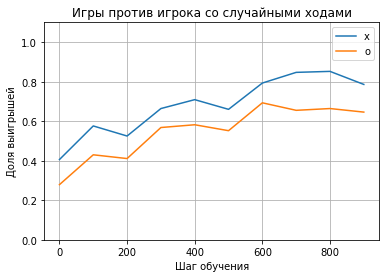

In [48]:
performances_crosses, performances_naughts = double_QN_train(double_agent_444, 
                                                       env_444, 
                                                       replay_buffer_444
                                                      )
plot_results(performances_crosses, performances_naughts)

In [49]:
print(test_perf(env_444, double_agent_444, random_agent))
print(test_perf(env_444, random_agent, double_agent_444))
print(test_perf(env_444, double_agent_444, double_agent_444))

(0.817, 0.079)
(0.119, 0.693)
(0.0, 1.0)


In [50]:
print(test_perf(env_444, double_agent_444, QL_agent_444))
print(test_perf(env_444, QL_agent_444, double_agent_444))

(0.0, 0.0)
(1.0, 0.0)


In [51]:
print(test_perf(env_444, DQN_agent_444, double_agent_444))
print(test_perf(env_444, double_agent_444, DQN_agent_444))

(1.0, 0.0)
(0.0, 1.0)


### Double DQN 5x5x5

In [52]:
replay_buffer_555 = ReplayBufferSet(10000, env_555)
double_agent_555 = DoubleQNAgent(env_555)

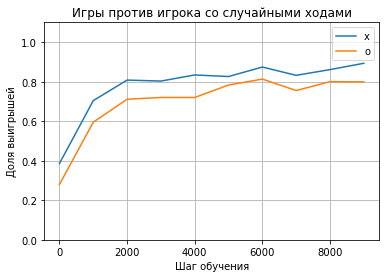

In [53]:
performances_crosses, performances_naughts = double_QN_train(double_agent_555, 
                                                       env_555, 
                                                       replay_buffer_555,
                                                       n_games=10000, 
                                                       perf_interval=1000
                                                      )
plot_results(performances_crosses, performances_naughts)

In [54]:
print(test_perf(env_555, double_agent_555, random_agent))
print(test_perf(env_555, random_agent, double_agent_555))
print(test_perf(env_555, double_agent_555, double_agent_555))

(0.835, 0.015)
(0.059, 0.74)
(0.0, 0.0)


In [55]:
print(test_perf(env_555, DQN_agent_555, double_agent_555))
print(test_perf(env_555, double_agent_555, DQN_agent_555))

(0.0, 0.0)
(0.0, 0.0)


### Часть третья: расширим и углубим поиск
Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

5.	Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
6.	Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.


In [56]:
class MCTSTreeNode(object):

    def __init__(self, env, board, parent=None):
        self.state_env = TicTacToe(env.n_rows, env.n_cols, env.n_win)
        self.state_env.board = copy.deepcopy(board)
        self.state_env.isTerminal()
        self.parent = parent
        self.children = []
        self.n = 0
        self.q = 0
        self.actions = list(self.state_env.getEmptySpaces())

    def best_child(self, c_param=1):
        choices_weights = [
            (-c.q / c.n) + 
                c_param * np.sqrt((2 * np.log(self.n) / c.n))
            for c in self.children
        ]
        return np.argmax(choices_weights)

    def expand(self):
        action = self.actions.pop(0)
        next_board = copy.deepcopy(self.state_env.board)
        next_board[action[0], action[1]] = self.state_env.curTurn
        child_node = MCTSTreeNode(self.state_env, next_board, parent=self)
        child_node.state_env.curTurn = -self.state_env.curTurn
        self.children.append(child_node)
        return child_node

    def rollout(self):
        rollout_env = TicTacToe(self.state_env.n_rows, 
                                self.state_env.n_cols, 
                                self.state_env.n_win)
        rollout_env.board = copy.deepcopy(self.state_env.board)
        rollout_env.curTurn = self.state_env.curTurn
        reward = rollout_env.isTerminal()
        done = rollout_env.gameOver
        random_actions = list(np.random.permutation(rollout_env.getEmptySpaces()))
        while not done:
            action = random_actions.pop()
            observation, reward, done, info = rollout_env.step(action)
        return reward * self.state_env.curTurn

    def backprop(self, result):
        self.n += 1.
        self.q += result
        if self.parent:
            self.parent.backprop(-result)

In [57]:
class MCTSAgent(object):
    def __init__(self, environment, n_simulations):
        self.index_best_action = True
        self.env = environment
        self.n_simulations = n_simulations
        
    def get_best_action(self, s, n_actions):
        board = np.array([float(n) for n in s]).reshape(
            (self.env.n_rows, self.env.n_cols)) - 1
        
        tree_root = MCTSTreeNode(self.env, board)
 
        for _ in range(self.n_simulations):            
            v = tree_root
            while not v.state_env.gameOver:
                if len(v.actions) > 0:
                    v = v.expand()
                else:
                    v = v.children[v.best_child()]
            reward = v.rollout()
            v.backprop(reward)
        return tree_root.best_child(c_param=0)

### Доска 3x3x3

In [58]:
MCTS_agent_333 = MCTSAgent(env_333, n_simulations=100)

In [59]:
print(test_perf(env_333, MCTS_agent_333, random_agent))
print(test_perf(env_333, random_agent, MCTS_agent_333))
print(test_perf(env_333, MCTS_agent_333, MCTS_agent_333))

(0.974, 0.0)
(0.317, 0.606)
(1.0, 0.0)


#### Сравниваем с агентами из предыдущих пунктов

In [60]:
print(test_perf(env_333, MCTS_agent_333, QL_agent_333))
print(test_perf(env_333, QL_agent_333, MCTS_agent_333))

(0.259, 0.0)
(0.952, 0.0)


In [61]:
print(test_perf(env_333, MCTS_agent_333, DQN_agent_333))
print(test_perf(env_333, DQN_agent_333, MCTS_agent_333))

(0.832, 0.0)
(0.753, 0.0)


In [62]:
print(test_perf(env_333, MCTS_agent_333, double_agent_333))
print(test_perf(env_333, double_agent_333, MCTS_agent_333))

(0.145, 0.0)
(1.0, 0.0)


### Доска 4x4x4

In [63]:
MCTS_agent_444 = MCTSAgent(env_444, n_simulations=100)
print(test_perf(env_444, MCTS_agent_444, random_agent))
print(test_perf(env_444, random_agent, MCTS_agent_444))
print(test_perf(env_444, MCTS_agent_444, MCTS_agent_444))

(0.895, 0.041)
(0.005, 0.77)
(0.086, 0.756)


#### Сравниваем с агентами из предыдущих пунктов

In [64]:
print(test_perf(env_444, MCTS_agent_444, QL_agent_444))
print(test_perf(env_444, QL_agent_444, MCTS_agent_444))

(0.815, 0.125)
(0.0, 0.803)


In [65]:
print(test_perf(env_444, MCTS_agent_444, DQN_agent_444))
print(test_perf(env_444, DQN_agent_444, MCTS_agent_444))

(0.522, 0.421)
(0.002, 0.44)


In [66]:
print(test_perf(env_444, MCTS_agent_444, double_agent_444))
print(test_perf(env_444, double_agent_444, MCTS_agent_444))

(0.808, 0.188)
(0.0, 0.96)


### Доска 5x5x5

In [67]:
MCTS_agent_555 = MCTSAgent(env_555, n_simulations=100)
print(test_perf(env_555, MCTS_agent_555, random_agent))
print(test_perf(env_555, random_agent, MCTS_agent_555))
print(test_perf(env_555, MCTS_agent_555, MCTS_agent_555))

(0.91, 0.0)
(0.053, 0.854)
(1.0, 0.0)


#### Сравниваем с агентами из предыдущих пунктов

In [68]:
print(test_perf(env_555, MCTS_agent_555, DQN_agent_555))
print(test_perf(env_555, DQN_agent_555, MCTS_agent_555))

(1.0, 0.0)
(0.0, 1.0)


In [69]:
print(test_perf(env_555, MCTS_agent_555, double_agent_555))
print(test_perf(env_555, double_agent_555, MCTS_agent_555))

(0.891, 0.009)
(1.0, 0.0)
